# Machine Learning Modelle
1. [Multiple Lineare Regression](#1)
1. [Random Forest](#2)
1. [XGBoost](#3)
1. [Optimierung XGBoost](#4)
  1. [Permutation Importance](#5)
  1. [F-Score](#6)
  1. [SHAP Values](#7)
1. [Grafische Darstellung](#8)

In [1]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/89/29/d5d086caa378240deb5d5e90982c772a8c4367e8688fb80754598ee35d14/darts-0.27.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.0 MB/s eta 0:00:00
  Obtaining dependency information for nfoursid>=1.0.0 from https://files.pythonhosted.org/packages/0a/92/dda081df8d207b72e419ef5dbd6a861041ceabdc609557249f334555a619/nfoursid-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/95/

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mae, rmse

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

ONE_DAY = 24
ONE_WEEK = ONE_DAY * 7

PAST_COV = ['outdoor_temp', 'app_outdoor_temp', 'humidity', 'air', 'bathroom', 'car', 'clotheswasher', 'dishwasher', 'drye',
            'dryg', 'furnace', 'kitchenapp', 'livingroom', 'microwave', 'oven', 'refrigerator', 'utilityroom', 'venthood']
FUTURE_COV = ['is_holiday', 'hour', 'wday', 'day', 'month', 'is_off_day', 'arima_preds',
              'arima_preds_m', 'es_preds', 'prophet_preds', 'use_is_na']

LAGS = [-1, -2, -3, -ONE_DAY, -2*ONE_DAY, -3*ONE_DAY]
FUTURE_LAGS = [0, 1, 2, 3]
PAST_LAGS = ONE_WEEK - len(FUTURE_LAGS) - 1

print("Setup complete")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Setup complete


In [3]:
def predict_daily(series, model, use_cov=True):
    """
    Erstellt eine Vorhersage für die bereitgestellten Daten mit dem angegebenen Modell.
    :param df: Ein Dataframe, der einen Zeitstempel und eine Spalte 'use' mit realen Messwerten enthält.
    :param model: Ein angepasstes Modell aus der darts Bibliothek.
    :return: Eine Liste aller Vorhersagen für das entsprechende Modell.
    """
    if use_cov:
        historical_forecast = model.historical_forecasts(
            series=series['use'],
            past_covariates=series[PAST_COV],
            future_covariates=series[FUTURE_COV],
            train_length=ONE_WEEK,
            forecast_horizon=ONE_DAY,
            last_points_only=False,
            stride=ONE_DAY,
            verbose=True
        )
    else:
        historical_forecast = model.historical_forecasts(
            series=series['use'],
            train_length=ONE_WEEK,
            forecast_horizon=ONE_DAY,
            last_points_only=False,
            stride=ONE_DAY,
            verbose=True
        )
    
    comb_df = pd.DataFrame()
    
    for fold in historical_forecast:
        preds = fold.pd_dataframe()
        comb_df = pd.concat([comb_df, preds])
    
    return comb_df


def eval_model(df, model_str):
    """
    Berechnet MAE und RMSE zwischen den tatsächlichen und vorhergesagten Werten und gibt diese in der Konsole aus.
    :param df: Ein Dataframe, der eine Spalte 'use' mit tatsächlichen Messwerten und
               eine Spalte mit vorhergesagten Werten für das entsprechende Modell enthält.
    :param model_str: Der Name der Spalte für die vorhergesagten Werte.
    """
    # In darts TimeSeries Objekte konvertieren
    actual = TimeSeries.from_values(df['use'])
    predicted = TimeSeries.from_values(df[model_str])
    
    avg_mae = round(mae(actual, predicted), 2)
    avg_rmse = round(rmse(actual, predicted), 2)
    
    print(f"MAE: {avg_mae}, RMSE: {avg_rmse}")

In [4]:
df = pd.read_csv("../input/2024-02-25/benchmark_models.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)

# Erste Woche auslassen, da hierfür keine Benchmark Vorhersagen existieren
df = df[ONE_WEEK:]
df_save = df.copy()

df.head()

,use,outdoor_temp,app_outdoor_temp,humidity,is_holiday,hour,wday,day,month,is_off_day,...,microwave,oven,refrigerator,utilityroom,venthood,use_is_na,arima_preds,arima_preds_m,es_preds,prophet_preds
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,0.34850,13.21,13.21,0.75,False,0,0,8,1,False,...,0.0,0.008,0.0,0.0,0.0,False,0.609486,0.609486,0.220875,0.625086
2018-01-08 01:00:00,0.33400,12.36,12.36,0.66,False,1,0,8,1,False,...,0.0,0.008,0.0,0.0,0.0,False,0.707786,0.707786,0.145688,0.565375
2018-01-08 02:00:00,0.24725,11.92,11.92,0.64,False,2,0,8,1,False,...,0.0,0.008,0.0,0.0,0.0,False,0.765565,0.765565,-0.023472,0.343196
2018-01-08 03:00:00,0.34775,11.33,11.33,0.66,False,3,0,8,1,False,...,0.0,0.008,0.0,0.0,0.0,False,0.799528,0.799528,0.005394,0.399465
2018-01-08 04:00:00,0.31900,10.86,10.86,0.61,False,4,0,8,1,False,...,0.0,0.008,0.0,0.0,0.0,False,0.819490,0.819490,0.017725,0.515787


In [5]:
# In darts TimeSeries Objekt konvertieren
series = TimeSeries.from_series(df)

<a id="1"></a>
## 1. Multiple Lineare Regression

In [6]:
from darts.models import LinearRegressionModel

lr_model_wof = LinearRegressionModel(lags=LAGS)

lr_str_wof = "lr_preds_wof"
df_save[lr_str_wof] = predict_daily(series, lr_model_wof, use_cov=False)
eval_model(df_save, lr_str_wof)

  0%|          | 0/351 [00:00<?, ?it/s]

MAE: 0.75, RMSE: 1.1


In [7]:
lr_model = LinearRegressionModel(
    lags=LAGS,
    lags_past_covariates=PAST_LAGS,
    lags_future_covariates=FUTURE_LAGS
)

lr_str = "lr_preds"
df_save[lr_str] = predict_daily(series, lr_model)
eval_model(df_save, lr_str)

  0%|          | 0/351 [00:00<?, ?it/s]

MAE: 1.12, RMSE: 1.52


<a id="2"></a>
## 2. Random Forest

In [8]:
# Anzahl der Bäume im Wald
n_estimators = [100, 200, 300, 400, 500]
# Anzahl der Features, die bei der Suche nach dem besten Split berücksichtigt werden sollen
max_features = [None, 'sqrt', 'log2']
# Maximale Tiefe der Bäume
max_depth = [None, 10, 20, 30, 40, 50]
# Minimale Anzahl von Samples, die benötigt werden, um einen internen Knoten zu teilen
min_samples_split = [2, 5, 10]
# Minimale Anzahl von Samples, die ein Blattknoten haben muss
min_samples_leaf = [1, 2, 4]
# Ob Bootstrap-Proben beim Aufbau der Bäume verwendet werden sollen
bootstrap = [True, False]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}

In [9]:
n_param_combs = len(n_estimators) * len(max_features) * len(max_depth) * len(min_samples_split) * len(min_samples_leaf) * len(bootstrap)
print(f"Um das optimale Modell zu finden, müssen {n_param_combs} Parameterkombinationen getestet werden")

# best_model, best_params, _ = RandomForest.gridsearch(
#     parameters=rf_grid,
#     series=series['use'],
#     past_covariates=series[PAST_COV],
#     future_covariates=series[FUTURE_COV],
#     forecast_horizon=ONE_DAY,
#     last_points_only=False,
#     stride=ONE_DAY,
#     metric=mae,
#     verbose=True
# )

Um das optimale Modell zu finden, müssen 1620 Parameterkombinationen getestet werden


Da die gridsearch() Methode aus der darts Bibliothek keine randomisierte Suche unterstützt und für dieses Modell eine Berechnungszeit von mehreren Tagen hätte, wird das optimale Modell mit RandomizedSeachCV aus der sklearn Bibliothek ermittelt. Außerdem wird nur eine auswählte Woche betrachtet, um die lokal optimalen Modellparamter zu finden

In [10]:
# Modellparameter werden auf Grundlage der ersten Woche bestimmt
train_data = df.head(ONE_WEEK)
df = df.drop(train_data.index)
train_y = train_data.use
train_X = train_data.drop('use', axis=1)

# In darts TimeSeries Objekt konvertieren
series = TimeSeries.from_series(df)

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_rsearch = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rf_grid, n_jobs=-1)
rf_rsearch.fit(train_X, train_y)
best_rf_params = rf_rsearch.best_params_

best_rf_params

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': None,
 'bootstrap': False}

In [12]:
from darts.models import RandomForest

rf_model = RandomForest(
    lags=LAGS,
    lags_past_covariates=PAST_LAGS,
    lags_future_covariates=FUTURE_LAGS,
    **best_rf_params
)

rf_str = "rf_preds"
df_save[rf_str] = predict_daily(series, rf_model)
eval_model(df_save, rf_str)

  0%|          | 0/344 [00:00<?, ?it/s]

MAE: 0.93, RMSE: 1.41


<a id="3"></a>
## 3. XGBoost

In [13]:
xgb_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

In [14]:
from xgboost import XGBRegressor

xgb_rsearch = RandomizedSearchCV(estimator=XGBRegressor(), param_distributions=xgb_grid, n_jobs=-1)
xgb_rsearch.fit(train_X, train_y)
best_xgb_params = xgb_rsearch.best_params_

best_xgb_params

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'subsample': 1.0,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 0.9}

In [15]:
from darts.models import XGBModel

xgb_model = XGBModel(
    lags=LAGS,
    lags_past_covariates=PAST_LAGS,
    lags_future_covariates=FUTURE_LAGS,
    **best_xgb_params
)

xgb_str = "xgb_preds"
df_save[xgb_str] = predict_daily(series, xgb_model)
eval_model(df_save, xgb_str)

  0%|          | 0/344 [00:00<?, ?it/s]

MAE: 0.73, RMSE: 1.09


<a id="4"></a>
## 4. Optimierung XGBoost

In [16]:
def add_lag_features(df, columns):
    """
    Fügt einem DataFrame Verzögerungs-Features (Lags) für die angegebenen Spalten hinzu.
    Für jede Spalte in 'columns' wird ein Verzögerungs-Feature hinzugefügt.
    Jedes Verzögerungs-Feature ist eine Verschiebung der Originalspalte um eine Stunde.

    :param df: Pandas DataFrame, zu dem die Verzögerungs-Features hinzugefügt werden sollen.
    :param columns: Liste der Spaltennamen, für die Verzögerungs-Features erstellt werden sollen.
    :return: DataFrame mit den zusätzlichen Verzögerungs-Features.
    """
    lagged_df = df.copy()
    for column in columns:
        lagged_df[f'{column}_lag_1'] = lagged_df[column].shift(1)
    return lagged_df


def add_use_lags(df, lag_hours):
    """
    Fügt einem DataFrame Verzögerungs-Features (Lags) für die Spalten 'use' hinzu. 
    Für jeden Verzögerungswert in 'lag_hours' wird ein Verzögerungs-Feature hinzugefügt.
    Jedes Verzögerungs-Feature ist eine Verschiebung der Originalspalte um X Stunden.

    :param df: Pandas DataFrame, zu dem die Verzögerungs-Features hinzugefügt werden sollen.
    :param lag_hours: Liste der Verzögerungswerte, für die Verzögerungs-Features erstellt werden sollen.
    :return: DataFrame mit den zusätzlichen Verzögerungs-Features.
    """
    lagged_df = df.copy()
    for lag in lag_hours:
        lagged_df[f'use_lag_{abs(lag)}'] = lagged_df.use.shift(lag)
    return lagged_df

In [17]:
# Verzögerungs-Features hinzufügen und zukunftsbezogene Features entfernen, um Data Leakage zu verhindern
df = add_lag_features(df, PAST_COV)
df.drop(PAST_COV, axis=1, inplace=True)

# Mehrere Verzögerungs-Features für Spalte use
df = add_use_lags(df, LAGS)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8424 entries, 2018-01-15 00:00:00 to 2018-12-31 23:00:00
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   use                     8424 non-null   float64
 1   is_holiday              8424 non-null   bool   
 2   hour                    8424 non-null   int64  
 3   wday                    8424 non-null   int64  
 4   day                     8424 non-null   int64  
 5   month                   8424 non-null   int64  
 6   is_off_day              8424 non-null   bool   
 7   use_is_na               8424 non-null   bool   
 8   arima_preds             8424 non-null   float64
 9   arima_preds_m           8424 non-null   float64
 10  es_preds                8424 non-null   float64
 11  prophet_preds           8424 non-null   float64
 12  outdoor_temp_lag_1      8423 non-null   float64
 13  app_outdoor_temp_lag_1  8423 non-null   float64
 14  humi

In [18]:
test_xgb_df = pd.DataFrame()
xgb_str_opt = "xgb_preds_opt"
predicted_day_start_idx = ONE_WEEK

while predicted_day_start_idx + ONE_DAY < len(df):
    day_count = (predicted_day_start_idx - ONE_WEEK) // ONE_DAY
    print(f"Day {day_count}/342")
    
    train_start = predicted_day_start_idx - ONE_WEEK
    train_end = predicted_day_start_idx
    test_start = train_end
    test_end = train_end + ONE_DAY
    train_data = df[train_start:train_end]
    test_data = df[test_start:test_end]
    
    train_y = train_data.use
    train_X = train_data.drop('use', axis=1)
    test_y = test_data.use
    test_X = test_data.drop('use', axis=1)
    
    test_xgb_model = XGBRegressor(early_stopping_rounds=20, **best_xgb_params)
    test_xgb_model.fit(
        train_X,
        train_y,
        eval_metric="mae",
        eval_set=[(train_X, train_y), (test_X, test_y)],
        verbose=False
    )
    xgb_predictions = test_xgb_model.predict(test_X)
    
    temp_df = pd.DataFrame(test_y)
    temp_df[xgb_str_opt] = xgb_predictions
    test_xgb_df = pd.concat([test_xgb_df, temp_df])
    
    predicted_day_start_idx += ONE_DAY

df_save[xgb_str_opt] = test_xgb_df[xgb_str_opt]

Day 0/342
Day 1/342
Day 2/342
Day 3/342
Day 4/342
Day 5/342
Day 6/342
Day 7/342
Day 8/342
Day 9/342
Day 10/342
Day 11/342
Day 12/342
Day 13/342
Day 14/342
Day 15/342
Day 16/342
Day 17/342
Day 18/342
Day 19/342
Day 20/342
Day 21/342
Day 22/342
Day 23/342
Day 24/342
Day 25/342
Day 26/342
Day 27/342
Day 28/342
Day 29/342
Day 30/342
Day 31/342
Day 32/342
Day 33/342
Day 34/342
Day 35/342
Day 36/342
Day 37/342
Day 38/342
Day 39/342
Day 40/342
Day 41/342
Day 42/342
Day 43/342
Day 44/342
Day 45/342
Day 46/342
Day 47/342
Day 48/342
Day 49/342
Day 50/342
Day 51/342
Day 52/342
Day 53/342
Day 54/342
Day 55/342
Day 56/342
Day 57/342
Day 58/342
Day 59/342
Day 60/342
Day 61/342
Day 62/342
Day 63/342
Day 64/342
Day 65/342
Day 66/342
Day 67/342
Day 68/342
Day 69/342
Day 70/342
Day 71/342
Day 72/342
Day 73/342
Day 74/342
Day 75/342
Day 76/342
Day 77/342
Day 78/342
Day 79/342
Day 80/342
Day 81/342
Day 82/342
Day 83/342
Day 84/342
Day 85/342
Day 86/342
Day 87/342
Day 88/342
Day 89/342
Day 90/342
Day 91/34

In [19]:
eval_model(df_save, xgb_str_opt)

MAE: 0.45, RMSE: 0.75


<a id="4"></a>
## A. Permutation Importance

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(test_xgb_model).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=test_X.columns.tolist())

Weight,Feature
0.2154 ± 0.1229,car_lag_1
0.2043 ± 0.1790,use_lag_1
0.0225 ± 0.0197,use_lag_24
0.0095 ± 0.0599,humidity_lag_1
0.0052 ± 0.0051,arima_preds
0.0051 ± 0.0069,refrigerator_lag_1
0.0033 ± 0.0118,use_lag_3
0.0026 ± 0.0072,venthood_lag_1
0.0021 ± 0.0039,hour
0.0013 ± 0.0209,furnace_lag_1


<a id="5"></a>
## B. F-Score
F-Score:

Dieser basiert in der Regel auf der Anzahl der Male, dass ein Feature beim Aufbau der Bäume im Modell verwendet wird.
In Entscheidungsbaum-basierten Modellen wie XGBoost bedeutet ein höherer F-Score, dass das Feature häufiger verwendet wird, um die Bäume zu teilen, was auf eine höhere Wichtigkeit hindeutet.
Dies ist eine intrinsische Methode, die direkt aus dem Trainingsprozess des Modells stammt.


Permutationswichtigkeit (Permutation Importance):

Bei der Permutationswichtigkeit wird die Wichtigkeit eines Features durch das Mischen (Permutieren) der Werte dieses Features über die Beobachtungen hinweg und das Beobachten der Auswirkungen auf die Modellleistung ermittelt.
Wenn die Permutation eines Features zu einer erheblichen Verschlechterung der Modellleistung führt, deutet dies darauf hin, dass das Feature wichtig ist.
Diese Methode ist modellagnostisch, was bedeutet, dass sie unabhängig vom verwendeten Modelltyp funktioniert. Sie misst den Einfluss eines Features auf die Vorhersagegenauigkeit des Modells.


Der Hauptunterschied zwischen diesen beiden Methoden liegt in ihrer Herangehensweise:

Der F-Score gibt an, wie oft ein Feature beim Aufbau der Bäume eines Entscheidungsbaummodells verwendet wurde. Es ist eine direktere Messung basierend auf dem Trainingsprozess des Modells.
Die Permutationswichtigkeit misst, wie sich die Vorhersageleistung des Modells ändert, wenn die Werte eines Features zufällig geändert werden. Sie gibt Aufschluss darüber, wie sich die Unordnung eines Features auf die Genauigkeit des Modells auswirkt.
Beide Methoden können nützliche Einblicke in die Wichtigkeit von Features geben, aber sie können unterschiedliche Ergebnisse liefern, je nach den Eigenschaften der Daten und des Modells. In der Praxis ist es oft sinnvoll, beide Methoden zu verwenden, um ein umfassenderes Bild der Feature-Wichtigkeit zu erhalten.

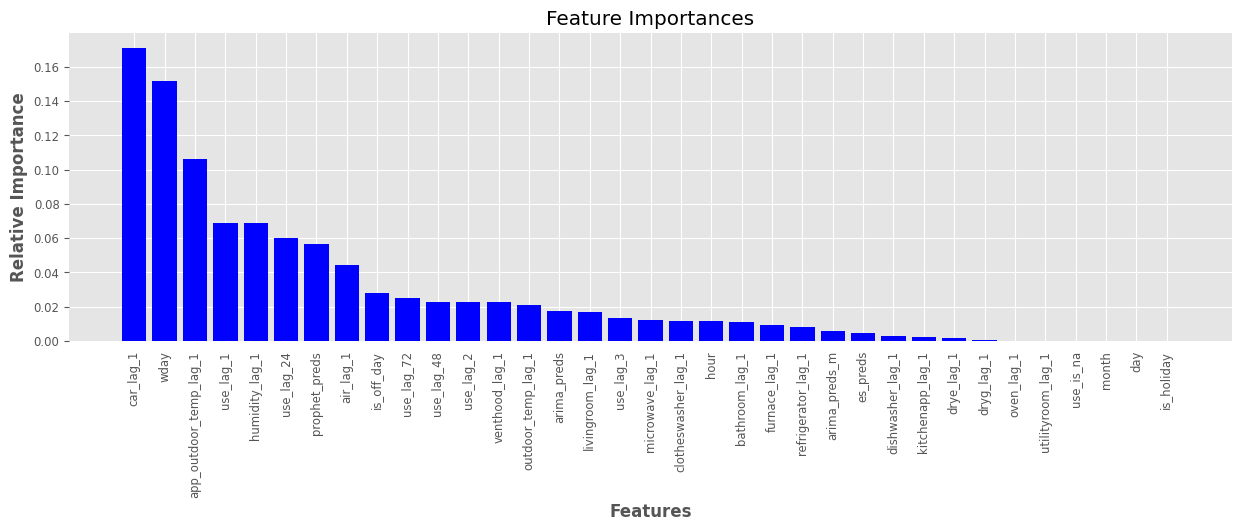

In [21]:
# Feature Labels
feature_labels = train_X.columns

# Extrahieren der Feature-Importances
feature_importances = test_xgb_model.feature_importances_

# Überprüfen, ob die Anzahl der Features übereinstimmt
if len(feature_labels) != len(feature_importances):
    raise ValueError("Die Anzahl der Features im Modell stimmt nicht mit der Anzahl der ursprünglichen Features überein.")
    
# Zuordnung der Feature-Namen
importance_df = pd.DataFrame({'feature': feature_labels, 'importance': feature_importances})
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Erstellen des Plots
plt.figure(figsize=(15, 4))
plt.title("Feature Importances")
plt.bar(importance_df.feature, importance_df.importance, color='b')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

<a id="6"></a>
## C. SHAP Values

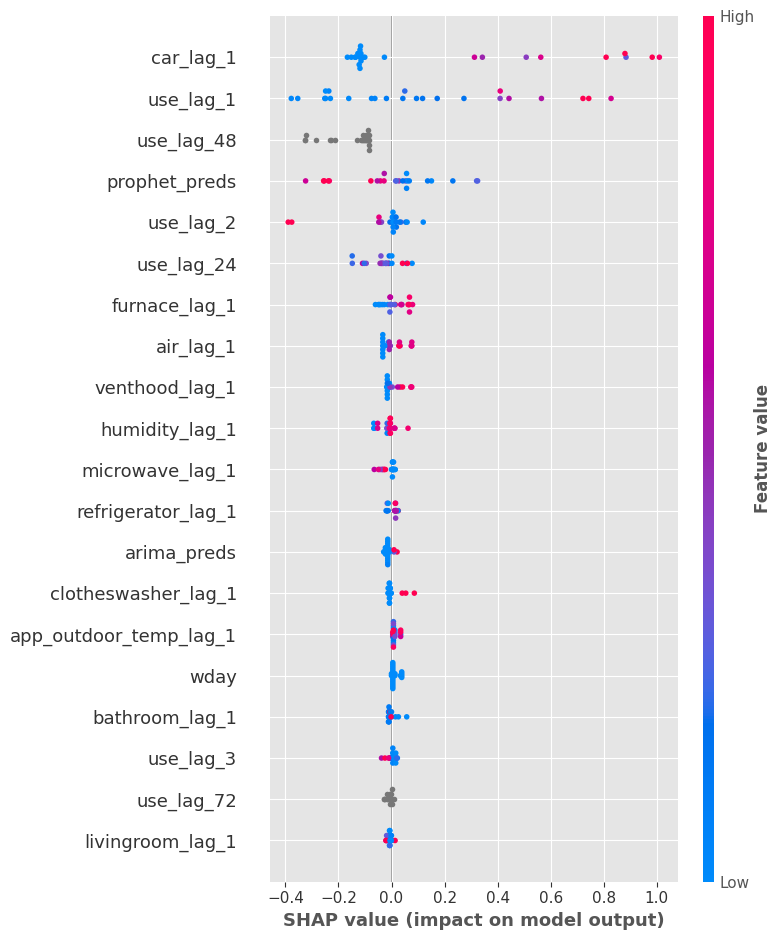

In [22]:
import shap

explainer = shap.TreeExplainer(test_xgb_model)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

Interpretation:
* Vertical location shows what feature it is depicting
* Color shows whether that feature was high or low for that row of the dataset
* Horizontal location shows whether the effect of that value caused a higher or lower prediction.

Wenn use_lag_1 einen hohen Wert hat, wird ein hoher Verbrauch vorhergesagt.

Wenn use_lag_2 einen hohen Wert hat, wird ein niedriger Verbrauch vorhergesagt.

In [23]:
row_to_show = 5

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[row_to_show], test_X.iloc[row_to_show])

<a id="7"></a>
## 5. Grafische Darstellung

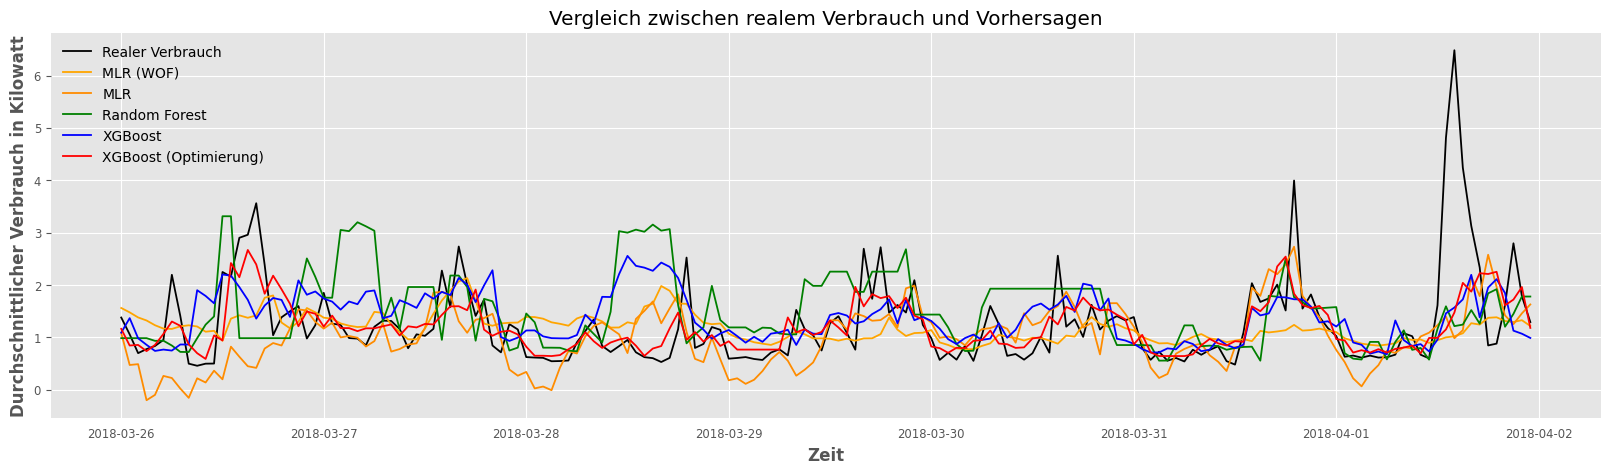

In [24]:
offset = 11
df_plot = df_save[ONE_WEEK*offset:ONE_WEEK*(offset+1)]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.index, df_plot.use, color='black', label='Realer Verbrauch')
plt.plot(df_plot.index, df_plot.lr_preds_wof, color='orange', label='MLR (WOF)')
plt.plot(df_plot.index, df_plot.lr_preds, color='darkorange', label='MLR')
plt.plot(df_plot.index, df_plot.rf_preds, color='green', label='Random Forest')
plt.plot(df_plot.index, df_plot.xgb_preds, color='blue', label='XGBoost')
plt.plot(df_plot.index, df_plot.xgb_preds_opt, color='red', label='XGBoost (Optimierung)')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch in Kilowatt')
plt.legend()
plt.show()